In [2]:
import pandas as pd
import numpy as np
import ast
#import seaborn
from collections import Counter
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
from bs4 import BeautifulSoup

In [3]:
def load(filename):
    file = open(filename,'rb')
    obj = pickle.load(file)
    file.close()
    return obj

def dump(obj,filename):
    filehandler = open(filename,"wb")
    pickle.dump(obj,filehandler)
    filehandler.close()

In [5]:
pitt_review = load("../../Pickled_files/pitt_review.pkl")
pitt_review["word_freq"] = map(lambda x: Counter(x),pitt_review["clean_text"])


In [126]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import matplotlib as mpl

def myFormatter(x, pos):
    return pd.to_datetime(x,format="%Y-%m").year

In [7]:
pitt_review["date"] = map(lambda x: pd.datetime.strptime(x, '%Y-%m-%d'),pitt_review["date"])
pitt_review["month"] = map(lambda x: x.month , pitt_review["date"])
pitt_review["year"] = map(lambda x: x.year , pitt_review["date"])
pitt_review["nreviews"] = 1 

In [128]:
def plot_word_trends(word_list,name="",wind=5):
    
    temp = pitt_review.copy()
    
    if len(name) > 0:
        temp = temp[temp["name"]==name]

        
    for words in word_list:
        temp["x"] = 0
        for word in words:
            temp["x"] = temp["x"] | map(lambda x: 1 if x[word] > 0 else 0, temp["word_freq"])
        word_name = "_".join(words)
        temp[word_name] =  temp["x"]

    words = map(lambda x: "_".join(x),word_list)
    
    feat = ["month","year","nreviews"] + words
    
    if len(name) > 0:
        feat = feat + ["stars_x"]
    
    avgStatspitt = temp.groupby(by=["year","month"]).sum()
        
    for word in words:
        avgStatspitt[word + "_prop"] = avgStatspitt[word]/avgStatspitt["nreviews"]
        avgStatspitt[word + "_prop"] = avgStatspitt[word + "_prop"].rolling(window = wind).mean()
        
    if len(name) > 0:
        avgStatspitt["stars_x"] = (avgStatspitt["stars_x"] - 1)/(avgStatspitt["nreviews"]*4)
        avgStatspitt["stars_x"] = avgStatspitt["stars_x"].rolling(window = wind).mean()
    
   
    
    feat_prop = map(lambda x: x + "_prop" ,words)
    avgStatspitt.reset_index(inplace=True)
    
    avgStatspitt = avgStatspitt[avgStatspitt["year"] > 2008]
    
    ym = zip(avgStatspitt["year"],avgStatspitt["month"])
    ym  = map(lambda x: str(x[0]) + "-" + str(x[1]),ym)
    avgStatspitt["date"] = map(lambda x: pd.datetime.strptime(x, '%Y-%m'),ym)
    
     
    if len(name) > 0:
        feat_prop = feat_prop + ["stars_x"]
    
    
    pm = pd.melt(avgStatspitt, id_vars=['date'], value_vars=feat_prop)
    pm["Dummy"] = 0
    
   
    
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.tsplot(data=pm, time="date", condition="variable",unit="Dummy", value="value",ax = ax)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(myFormatter))
    fig.autofmt_xdate()
    plt.show()

#### By Restaurant 
##### Here in the example say you want to group boolean word presence of two words say service and time because you might think they might related then put them in a single list
##### Note: When in a single list it plots rating as well

### You can also bin these multiple list by topics we have defined to see change in topics over time

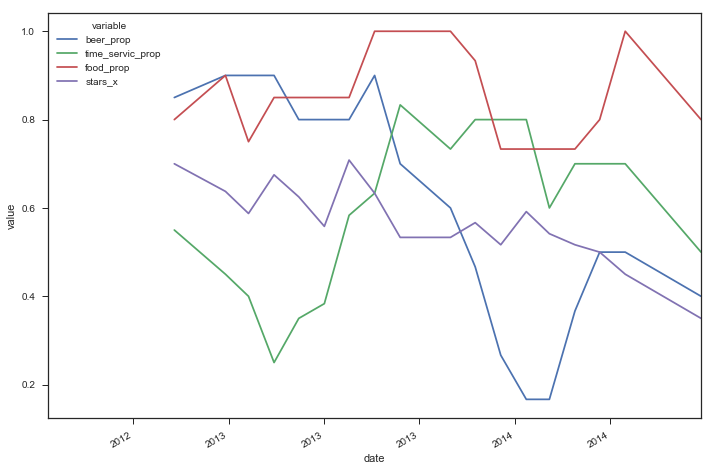

In [131]:
plot_word_trends(word_list = [["beer"],["time","servic"],["food"]],name="Brewstone",wind=5)

### This is not by restaurant in general

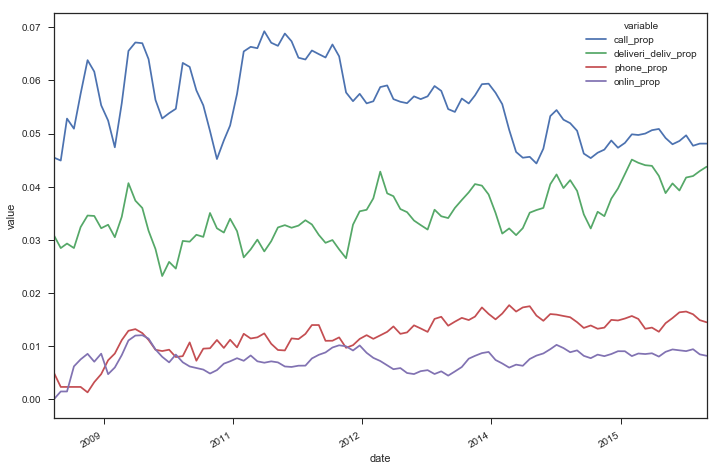

In [135]:
plot_word_trends(word_list = [["call"],["deliveri","deliv"],["phone"],["onlin"]],wind=5)

### Say you want to compare different  cusine in Pittsburgh

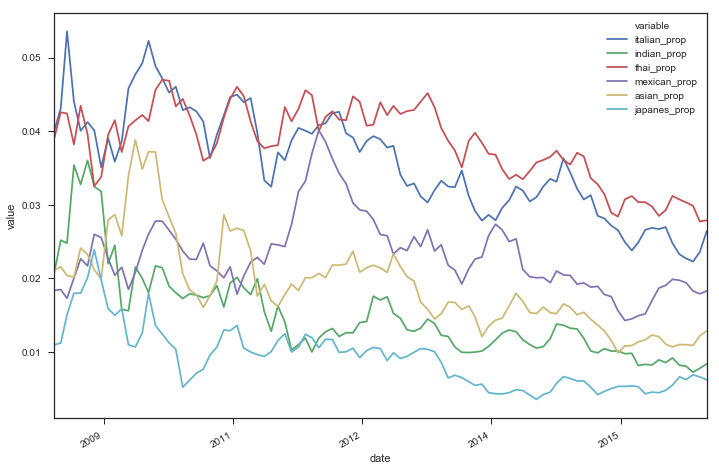

In [137]:
plot_word_trends(word_list = [["italian"],["indian"],["thai"],["mexican"],["asian"],["japanes"]],wind=5)